In [1]:
import numpy as np
import pickle
from copy import deepcopy
from scipy.interpolate import interp1d
from astropy.table import Table
import astropy.constants as const
import astropy.io.ascii as asci

In [2]:
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
fs = 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
z = 0.018
d_kpc = cosmo.luminosity_distance([z])[0].value * 1e+3
d_cm = d_kpc * 1e+3 * const.pc.cgs.value
scale = 4 * np.pi * d_cm**2 

In [4]:
def get_spectrum(num = 1, filename = "../data/Xray_yao_reduction/BestFit.qdp"):
    f = open(filename)
    lines = f.readlines()
    f.close()

    lines = lines[3:]
    sps = []
    count = 0
    for j in range(len(lines)):
        x =  lines[j]
        if x[:11] == 'NO NO NO NO':
            count +=1
            if count==num:
                break
            else:
                sps = []
        else:
            sps.append(x)
    return asci.read(sps)

    
def get_xray_nufnu(num = 1, filename="../data/Xray_yao_reduction/BestFit.qdp", ycol = None, 
                   fnu_unc_max = None, fnu_min = None, remove_softline = False):
    sp5 = get_spectrum(num = num, filename=filename)
    E = sp5["col1"] # keV
    nu = E * 1.6e-9 / const.h.cgs.value # Hz
    if ycol is None:
        E_unc = sp5["col2"] 
        nu_unc = E_unc * 1.6e-9 / const.h.cgs.value
        EfE = sp5["col3"] # keV^2 photon / cm^2 / s / keV
        EfE_unc = sp5["col4"]
        nufnu = EfE * 1.6e-9 # Hz erg / cm^2 / s / Hz
        nufnu_unc = EfE_unc * 1.6e-9
        fnu = nufnu / nu
        fnu_unc = nufnu_unc / nu
        tb = Table(data = [E, E_unc, EfE, EfE_unc, nu, nu_unc, fnu, fnu_unc, nufnu, nufnu_unc], 
                   names = ["E", "E_unc", "EfE", "EfE_unc",
                            "nu", "nu_unc", "fnu", "fnu_unc", "nufnu", "nufnu_unc"])
        if fnu_unc_max is not None:
            ix = tb["fnu_unc"] < fnu_unc_max
            tb = tb[ix]
    else:
        EfE = sp5[ycol] # keV^2 photon / cm^2 / s / keV
        nufnu = EfE * 1.6e-9 # Hz erg / cm^2 / s / Hz
        fnu = nufnu / nu
        tb = Table(data = [nu, fnu, E, EfE], names = ["nu", "fnu", "E", "EfE"])
    if fnu_min is not None:
        ix = tb["fnu"] > fnu_min
        tb = tb[ix]
    
    if remove_softline == True:
        ix = (tb["E"]>0.525)&(tb["E"]<0.53)
        tb = tb[~ix]
    tb = tb.to_pandas()
    tb["nufnu"] = tb["nu"] * tb["fnu"]
    return tb

In [5]:
def planck_fnu(nu, Tbb, Rbb):
    h = 6.62607E-27
    c = 2.99792458E10
    k_B = 1.38064852E-16
    temp = np.exp(h*nu/(k_B*Tbb))
    temp = np.array(temp)
    Inu = 2*h/c**2 * nu**3 / (temp-1) # erg/cm2/Hz/sr/s
    Lnu = (np.pi * Inu) * (4. * np.pi * Rbb**2) # erg/Hz/s
    #nuLnu = nu * Lnu # erg/s
    return Lnu  

In [6]:
def plot_xrt_fnu(ax, xfile1a, xfile1b, xfileubb, xfileupl):
    color = "k"
    zorder = 5
    alpha = 1
    lw = 2
    mec = "k"
    mod1 = get_xray_nufnu(num = 1, ycol = "col5", filename=xfile1a)
    mod2_bb = get_xray_nufnu(num = 1, ycol = "col3", filename=xfileubb)
    mod2_pl = get_xray_nufnu(num = 1, ycol = "col3", filename=xfileupl)
    
    mod2 = deepcopy(mod2_bb)
    for ycol in ["fnu", "nufnu", "EfE"]:
        #mod2_pl[ycol][ix2] = np.nan
        mod2[ycol] = mod2_bb[ycol] + mod2_pl[ycol]
        
    df1 = get_xray_nufnu(num = 1, filename=xfile1b) 
    myfunc_unabs = interp1d(mod2["nu"], mod2["nufnu"])
    myfunc_abs = interp1d(mod1["nu"], mod1["nufnu"])
    factor = myfunc_unabs(df1["nu"].values) / myfunc_abs(df1["nu"].values) 

    ax.errorbar(df1["nu"]*(1+z), df1["fnu"] * factor, 
                    df1["fnu_unc"] * factor, xerr = df1["nu_unc"]*(1+z), 
                    fmt = "s", color = color, markersize = 3, linewidth = lw,
                    zorder=zorder, alpha =alpha, markeredgecolor = mec,
                    markeredgewidth = 0.2)
    ix_obs = (mod2_bb["E"] > 0.3)&(mod2_bb["E"] < 10)
    ax.plot(mod2["nu"][ix_obs]*(1+z), mod2["fnu"][ix_obs], color = color, 
            linestyle = "-",
            linewidth = lw, zorder=zorder, alpha =alpha/2)
    
    x1 = 0.5 *1e+3 * 1.60218e-12 / const.h.cgs.value
    x2 = 10 *1e+3 * 1.60218e-12 / const.h.cgs.value
    
    xs = np.logspace(np.log10(x1), np.log10(x2))
    ys_upp = myfunc_unabs(xs) / xs
    ys_bot = np.ones(len(xs))*1e-31
    ax.fill_between(xs, ys_upp, ys_bot, color = color, alpha = 0.3)
    
    ax.plot([x1, x1], [1e-14, 4e-11], color = color, linestyle = ":", 
            alpha = 0.8)

    ax.arrow(x1, 2.8e-11/x1, 0, +0.8e-11/x1, head_length = 1E-11/x1, head_width = 2e+16,
             color = color)
    ax.text(x1*0.55, 5.2e-11/x1, r"$\rm 0.5\,keV$", color = color, fontsize = fs-1)
    
    x3 = 2 *1e+3 * 1.60218e-12 / const.h.cgs.value
    ax.plot([x3, x3], [1e-14/x3, 4e-12/x3], color = color, linestyle = ":", 
            alpha = 0.8, linewidth = 0.8)

    ax.arrow(x3, 4e-12/x3, 0, +1.5e-12/x3, head_length = 1.5e-12/x3, 
             width = 1e+15,
             head_width = 8e+16,
             color = color)
    ax.text(x3*0.6, 0.8e-11/x3, r"$\rm 2\,keV$", color = color, fontsize = fs-1)
    
    y1 = myfunc_unabs(x1)/x1
    
    print ("xray:", x1, y1)

In [7]:
def plot_EUV(ax):
    x1 = np.log10(1199169832000000.0)
    x2 = np.log10(1.2089971610095314e+17)
    y1 = np.log10(3.446019928013885e-27)
    y2 = np.log10(1.0824918084485468e-28)
    xs = np.logspace(x1, x2)
    ys = np.logspace(y1, y2)
    myfunc = interp1d(xs, ys)
    
    color = "rebeccapurple"
    ax.plot(xs, ys, color = color, alpha = 0.8, linewidth = 2, linestyle = "--")
    ax.fill_between(xs, myfunc(xs), color = color, alpha = 0.3)
    ax.text(5e+15, 6e-28, r"$f_\nu \propto \nu^{\alpha_{\rm OSX}}$", color = color,
            fontsize = fs-1, rotation = -25)

In [8]:
def plot_uvopt_fnu(ax, myphase = 150):
    color = "forestgreen"
    tb = asci.read("../data/opt_lc/phase_lum.dat")
    subfilename = "../data/opt_lc/subphase_lum.dat"
    subtb = asci.read(subfilename)
    with open('../data/opt_lc/waveinfo.pickle', 'rb') as handle:
        waveinfo = pickle.load(handle)
    filters = waveinfo["filters"]
    wv_filts = waveinfo["wv_filts"]
    nus_obs = 3e+10 / (wv_filts * 1e-8)
    nus = nus_obs * (1+z)
    
    filename_save = "../data/opt_lc/bbpars_ebv_0.00.dat"
    bbtb = asci.read(filename_save)
    
    subfilename_save = "../data/opt_lc/subbbpars_ebv_0.00.dat"
    subbbtb = asci.read(subfilename_save)

    ind = np.argsort(abs(tb["phase"].data-myphase))[0]
    indbb = np.argsort(abs(bbtb["phase"].data-myphase))[0]
    
    subind = np.argsort(abs(subtb["phase"].data-myphase))[0]
    subindbb = np.argsort(abs(subbbtb["phase"].data-myphase))[0]
    
    mainphase = tb["phase"].data[ind]
    subphase = subtb["phase"].data[subind]
    
    sep = abs(myphase - mainphase)
    subsep = abs(myphase - subphase)
    
    if sep  < subsep:
        dosub = False
    else:
        dosub = True
    
    verbose = True
    if verbose:
        print ("Specified phase = %d, phase in main table = %d, phase in sub table= %d"%(myphase, mainphase, subphase))
        if dosub:
            print ("  --> use sub table")
        else:
            print ("  --> use main table")
    
    lums = np.zeros(len(filters))
    elums = np.zeros(len(filters))
    
    for j in range(len(filters)):
        myfilter = filters[j]
        if dosub:
            lums[j] = subtb["%s-lum"%myfilter][subind] 
            elums[j] = subtb["%s-elum"%myfilter][subind] 
        else:
            lums[j] = tb["%s-lum"%myfilter][ind] 
            elums[j] = tb["%s-elum"%myfilter][ind] 
        
    if dosub:
        Topt = subbbtb["T"][subindbb]
        Ropt = subbbtb["R"][subindbb]
    else:
        Topt = bbtb["T"][indbb]
        Ropt = bbtb["R"][indbb]
    if verbose:
        print ("  T = %d K, R = %.2f e+14 cm"%(Topt, Ropt/1e+14))
    nus_plot = np.logspace(14.2, 15.7)
    Lnu_plot = planck_fnu(nus_plot, Topt, Ropt)
    ix = (elums / lums) < 0.5
    zorder = 5
    alpha = 1
    lum_nus = lums/nus
    elum_nus = elums/nus
    ax.errorbar(nus[ix], lum_nus[ix]/scale, elum_nus[ix]/scale, fmt = ".", color = color,
                markeredgecolor = "k",
                markeredgewidth = 0.4, zorder = zorder, markersize = ms+2,
                alpha=alpha)
    lw = 2
    ax.plot(nus_plot, Lnu_plot/scale, color = color, linewidth = lw,
            zorder = zorder, alpha=0.5)
    
    
    xs = np.logspace(np.log10(29979245800.0*1e+8/10000), np.log10(29979245800.0*1e+8/2500))
    ys_upp = planck_fnu(xs, Topt, Ropt) / scale
    ys_bot = np.ones(len(xs))*1e-31
    ax.fill_between(xs, ys_upp, ys_bot, color = color, alpha = 0.3)
    
    x1 = 29979245800.0*1e+8/2500
    ax.plot([x1, x1], [1e-30, 7e-27], color = color, linestyle = ":", 
            alpha = 0.8)

    ax.arrow(x1, 0.7e-11/x1, 0, +3e-12/x1, head_length = 3e-12/x1, head_width = 2e+14,
             color = color)
    ax.text(x1*0.55, 1.5e-11/x1, r"$\rm 2500\,\AA$", color = color, fontsize = fs-1)
    
    y1 = planck_fnu(x1, Topt, Ropt) / scale
    print ("UV/optical:", x1, y1)

In [9]:
def create_new_yticks1(ylims1, which = "major"):
    yticks1_new = []
    if which=="major":
        candi = np.logspace(15, 35, 21)
    else:
        candi = np.logspace(15, 35, 201)
    for yy in candi:
        if yy>ylims1[0] and yy<ylims1[1]:
            yticks1_new.append(yy)
    yticks1_new = np.array(yticks1_new)
    return yticks1_new

In [10]:
def create_new_xticks1(xlims1, which = "major"):
    xticks1_new = []
    if which=="major":
        candi = np.logspace(-5, 7, 13)
    else:
        candi = np.logspace(-5, 7, 121)
    for x in candi:
        if x>xlims1[1] and x<xlims1[0]:
            xticks1_new.append(x)
    xticks1_new = np.array(xticks1_new)
    return xticks1_new

In [11]:
def custom_ax(ax, xmin, xmax, ymin, ymax):
    ax.set_xlim(xmin, xmax)
    
    ax.semilogx()
    ax.semilogy()
    
    ax.set_ylim(ymin, ymax)
    
    ax.tick_params(which = 'major', length = 4, top=False, right=False, direction = "in")
    ax.tick_params(which = 'minor', length = 2, top=False, right=False, direction = "in")
    
    ax.set_xlabel(r"$\nu_{\rm rest}$"+" (Hz)")
    ax.set_ylabel(r"$f_{\nu}\, (\rm erg\,s^{-1}\, cm^{-2}\,Hz^{-1})$")

    
    ########## right y axis ##########
    # show luminosity
    
    axi2 = ax.twinx()
    ylims1 = (ymin*scale, ymax*scale)
    axi2.semilogy()
    
    yticks1_label = create_new_yticks1(ylims1, which = "major")
    yticks1_real = []
    for yy in yticks1_label:
        yticks1_real.append(yy/scale)
    yticks1_real = np.array(yticks1_real)
    
    yticks1_label_formatted = []
    for y in yticks1_label:
        yticks1_label_formatted.append(r"$10^{%d}$"%np.log10(y))
    
    yticks1_label_minor = create_new_yticks1(ylims1, which = "minor")
    yticks1_real_minor = []
    for y in yticks1_label_minor:
        yticks1_real_minor.append(y/scale)
    yticks1_real_minor = np.array(yticks1_real_minor)
    
    axi2.set_yticks(yticks1_real, minor = False)
    axi2.set_yticks(yticks1_real_minor, minor = True)
    axi2.set_ylim(ymin, ymax)
    axi2.set_yticklabels(yticks1_label_formatted, minor = False)
    axi2.set_yticklabels([], minor = True)
    axi2.set_ylabel(r"$L_{\nu}\,({\rm erg\,s^{-1}\,Hz^{-1}})$")
    
    #axi2.set_ylim(ymin, ymax)
   
    ########## upper x axis ##########
    # show rest frame wavelength
    axi1 = ax.twiny()
    xlims1 = (29979245800.0*1e+8/xmin, 29979245800.0*1e+8/xmax)
    axi1.semilogx()
    
    xticks1_label = create_new_xticks1(xlims1, which = "major")
    print (xticks1_label)
    xticks1_real = []
    for x in xticks1_label:
        xticks1_real.append(29979245800.0*1e+8/x)
    xticks1_real = np.array(xticks1_real)
    
    xticks1_label_formatted = []
    for x in xticks1_label:
        xticks1_label_formatted.append(r"$10^{%d}$"%np.log10(x))
    
    xticks1_label_minor = create_new_xticks1(xlims1, which = "minor")
    xticks1_real_minor = []
    for x in xticks1_label_minor:
        xticks1_real_minor.append(29979245800.0*1e+8/x)
    xticks1_real_minor = np.array(xticks1_real_minor)
    
    axi1.set_xticks(xticks1_real, minor = False)
    axi1.set_xticks(xticks1_real_minor, minor = True)
    axi1.set_xlim(xmin, xmax)
    axi1.set_xticklabels(xticks1_label_formatted, minor = False)
    axi1.set_xticklabels([], minor = True)
    axi1.set_xlabel(r"$\lambda_{\rm rest}\;(\rm \AA)$")
    
    ax.set_xlim(xmin, xmax)
    
    axi1.tick_params(which = 'major', length = 4, direction = "in")
    axi1.tick_params(which = 'minor', length = 2, direction = "in")
    axi2.tick_params(which = 'major', length = 4, direction = "in")
    axi2.tick_params(which = 'minor', length = 2, direction = "in")
    

Specified phase = 147, phase in main table = 147, phase in sub table= 217
  --> use main table
  T = 23228 K, R = 1.65 e+14 cm
UV/optical: 1199169832000000.0 3.446019928013615e-27
xray: 1.2089971610095314e+17 1.0824918084485468e-28
[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


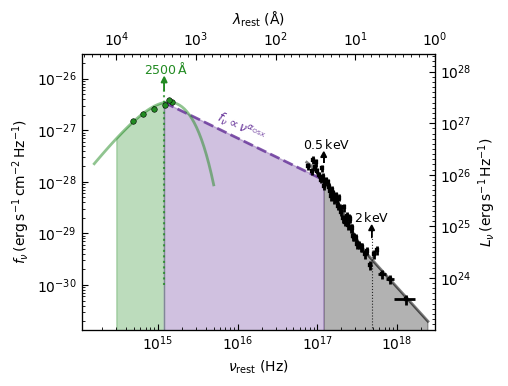

In [12]:
    fig = plt.figure(figsize = (4.8, 3.6))
    ax = plt.subplot(111)
    plot_uvopt_fnu(ax, myphase = 147)
    
    xfile1a = "../data/xrt/spec/s3/eeufspec_ratio_fix_1_100.qdp"
    xfile1b = "../data/xrt/spec/s3/eeufspec_ratio_fix_5_100.qdp"
    xfileubb = "../data/xrt/spec/s3/unabs_mod_bb.qdp"
    xfileupl = "../data/xrt/spec/s3/unabs_mod_pl.qdp"
    plot_xrt_fnu(ax, xfile1a, xfile1b, xfileubb, xfileupl)
    
    plot_EUV(ax)
    
    xmin = 1.1e+14
    xmax = 3e+18
    
    ymax = 3e-26
    ymin = 1e+23/scale
    
    custom_ax(ax, xmin, xmax, ymin, ymax)
    
    plt.tight_layout(rect = (-0.04, -0.05, 1.04, 1.05))
